In [3]:
# system / paths
import os
import sys
from pathlib import Path

# numerical / data
import numpy as np
import pandas as pd
import random

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# audio processing
import librosa
import soundfile as sf
# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# filtering and audio playback
from scipy.signal import butter, filtfilt
from IPython.display import Audio, display

# project paths
project_root = Path(os.getcwd()).parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# CWD is assumed to be notebooks/icbhi CWD = Path().resolve() # heart_and_lungsounds/ PROJECT_ROOT = CWD.parents[1]
CWD = Path().resolve()  # heart_and_lungsounds/
PROJECT_ROOT = CWD.parents[1]

PROC_KA = PROJECT_ROOT / "data" / "processed" / "ka"
KA_META_CSV = PROC_KA / "ka_meta_annotation_data.csv"

RAW_KA = PROJECT_ROOT / "data" / "raw" / "ka"
KA_AUDIO_DIR = RAW_KA / "audio_files"   # pas aan als jouw map anders heet

print("KA_META_CSV :", KA_META_CSV)
print("KA_AUDIO_DIR:", KA_AUDIO_DIR)

KA_META_CSV : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\ka\ka_meta_annotation_data.csv
KA_AUDIO_DIR: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\ka\audio_files


In [4]:
ka_df = pd.read_csv(KA_META_CSV)
print("ka_df shape:", ka_df.shape)
ka_df.head()

ka_df shape: (336, 13)


,file_name,filter_type,patient_id,diagnosis,sound_type,location,age,gender,samplerate,frames,duration_sec,channels,diagnosis_norm
0,"BP100_N,N,P R M,70,F.wav",B,P100,N,N,P R M,70,F,4000,54208,13.552,1,Normal
1,"BP101_Asthma,E W,P L M,12,F.wav",B,P101,Asthma,E W,P L M,12,F,4000,54208,13.552,1,Asthma
2,"BP102_N,N,P L L,41,M.wav",B,P102,N,N,P L L,41,M,4000,76224,19.056,1,Normal
3,"BP103_N,N,P R U,81,F.wav",B,P103,N,N,P R U,81,F,4000,51392,12.848,1,Normal
4,"BP104_Asthma,E W,P L U,45,F.wav",B,P104,Asthma,E W,P L U,45,F,4000,47040,11.760,1,Asthma


In [5]:
CHEST_LOCATION_MAP_KA = {
    "PRL": "Posterior right lower",
    "PLL": "Posterior left lower",
    "PRM": "Posterior right mid",
    "PRU": "Posterior right upper",
    "PLM": "Posterior left mid",
    "PLU": "Posterior left upper",
    "ARU": "Anterior right upper",
    "ARM": "Anterior right mid",
    "ARL": "Anterior right lower",
    "ALU": "Anterior left upper",
}


In [6]:
TARGET_SR = 4000

def load_ka_audio(file_name: str, audio_dir: Path, sr: int = TARGET_SR):
    wav_path = audio_dir / file_name
    if not wav_path.exists():
        raise FileNotFoundError(f"KA audio not found: {wav_path}")

    y, sr_loaded = librosa.load(str(wav_path), sr=sr, mono=True)
    return y, sr_loaded, wav_path

def attach_ka_audio(df: pd.DataFrame, audio_dir: Path, sr: int = TARGET_SR) -> pd.DataFrame:
    df = df.copy()

    audios, srs, paths = [], [], []
    for fn in df["file_name"]:
        y, sr_loaded, wav_path = load_ka_audio(fn, audio_dir, sr=sr)
        audios.append(y)
        srs.append(sr_loaded)
        paths.append(str(wav_path))

    df["audio"] = audios
    df["sr"] = srs
    df["audio_path"] = paths
    return df

ka_df = attach_ka_audio(ka_df, KA_AUDIO_DIR, sr=TARGET_SR)
ka_df.head()


,file_name,filter_type,patient_id,diagnosis,sound_type,location,age,gender,samplerate,frames,duration_sec,channels,diagnosis_norm,audio,sr,audio_path
0,"BP100_N,N,P R M,70,F.wav",B,P100,N,N,P R M,70,F,4000,54208,13.552,1,Normal,"[0.0, 0.0, 0.0, 0.0, -3.0517578e-05, -3.051757...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
1,"BP101_Asthma,E W,P L M,12,F.wav",B,P101,Asthma,E W,P L M,12,F,4000,54208,13.552,1,Asthma,"[0.0, 0.0, 0.0, 0.0, -3.0517578e-05, -3.051757...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
2,"BP102_N,N,P L L,41,M.wav",B,P102,N,N,P L L,41,M,4000,76224,19.056,1,Normal,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
3,"BP103_N,N,P R U,81,F.wav",B,P103,N,N,P R U,81,F,4000,51392,12.848,1,Normal,"[0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05, -3.0...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
4,"BP104_Asthma,E W,P L U,45,F.wav",B,P104,Asthma,E W,P L U,45,F,4000,47040,11.760,1,Asthma,"[0.0, 0.0, 0.0, 0.0, 0.0, 3.0517578e-05, 6.103...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...


In [7]:
def butter_bandpass_filter(
    x: np.ndarray,
    fs: float,
    lowcut: float = 120.0,
    highcut: float = 1800.0,
    order: int = 12,
) -> np.ndarray:
    """
    12th-order Butterworth band-pass filter (zero-phase via filtfilt).
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    if low <= 0 or high >= 1:
        raise ValueError(f"Invalid bandpass range: low={lowcut}, high={highcut}, fs={fs}")

    b, a = butter(order, [low, high], btype="bandpass")
    y = filtfilt(b, a, x)
    return y

def apply_ka_bandpass(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds 'filtered_audio' (Butterworth band-pass 120–1800 Hz @ 4 kHz).
    """
    df = df.copy()
    df["filtered_audio"] = df.apply(
        lambda row: butter_bandpass_filter(
            row["audio"], row["sr"], lowcut=120.0, highcut=1800.0, order=12
        ),
        axis=1,
    )
    return df

ka_df = apply_ka_bandpass(ka_df)
ka_df.head()


,file_name,filter_type,patient_id,diagnosis,sound_type,location,age,gender,samplerate,frames,duration_sec,channels,diagnosis_norm,audio,sr,audio_path,filtered_audio
0,"BP100_N,N,P R M,70,F.wav",B,P100,N,N,P R M,70,F,4000,54208,13.552,1,Normal,"[0.0, 0.0, 0.0, 0.0, -3.0517578e-05, -3.051757...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[0.002305793213411468, -0.0010046483761113915,..."
1,"BP101_Asthma,E W,P L M,12,F.wav",B,P101,Asthma,E W,P L M,12,F,4000,54208,13.552,1,Asthma,"[0.0, 0.0, 0.0, 0.0, -3.0517578e-05, -3.051757...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[0.002305793213411468, -0.0010046483761113915,..."
2,"BP102_N,N,P L L,41,M.wav",B,P102,N,N,P L L,41,M,4000,76224,19.056,1,Normal,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[0.0004074409806107508, 0.00017873416444369342..."
3,"BP103_N,N,P R U,81,F.wav",B,P103,N,N,P R U,81,F,4000,51392,12.848,1,Normal,"[0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05, -3.0...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[-0.0014440322418333, -0.001485480291223775, -..."
4,"BP104_Asthma,E W,P L U,45,F.wav",B,P104,Asthma,E W,P L U,45,F,4000,47040,11.760,1,Asthma,"[0.0, 0.0, 0.0, 0.0, 0.0, 3.0517578e-05, 6.103...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[9.086664578281388e-05, 0.0005082397186359593,..."


In [8]:
def plot_raw_vs_filtered_ka(
    row,
    time_window=(0.0, 10.0),
    fixed_ylim=(-0.5, 0.5),
):
    """
    Raw vs filtered waveform for a KA recording, with clean styling and playback.
    """
    y_raw = row["audio"]
    y_filt = row["filtered_audio"]
    sr = row["sr"]

    # window
    if time_window is not None:
        t0, t1 = time_window
        i0 = int(t0 * sr)
        i1 = int(t1 * sr)
        y_raw_plot = y_raw[i0:i1]
        y_filt_plot = y_filt[i0:i1]
        t = np.arange(len(y_raw_plot)) / sr + t0
    else:
        y_raw_plot = y_raw
        y_filt_plot = y_filt
        t = np.arange(len(y_raw_plot)) / sr

    # ticks
    x_min, x_max = float(t[0]), float(t[-1])
    x_ticks = np.arange(np.floor(x_min), np.ceil(x_max) + 1e-9, 0.5)

    y_min, y_max = fixed_ylim
    y_ticks = np.arange(y_min, y_max + 1e-9, 0.1)

    # metadata for title
    file_name = row.get("file_name", "unknown.wav")
    diag = str(row.get("diagnosis_norm", row.get("diagnosis", ""))).strip()
    loc_code = str(row.get("location", "")).strip()
    loc_full = CHEST_LOCATION_MAP_KA.get(loc_code, loc_code) if loc_code else ""

    title_parts = [file_name]
    if diag:
        title_parts.append(diag)
    if loc_full:
        title_parts.append(loc_full)
    suptitle = " – ".join(title_parts)

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
    fig.suptitle(suptitle, fontsize=12)

    # raw
    axes[0].plot(t, y_raw_plot, color="black", linewidth=0.7)
    axes[0].set_title("Raw signal", fontsize=11)
    axes[0].set_ylabel("Amplitude")
    axes[0].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[0].set_xticks(x_ticks)
    axes[0].set_yticks(y_ticks)
    axes[0].grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.9)

    # filtered
    axes[1].plot(t, y_filt_plot, color="black", linewidth=0.7)
    axes[1].set_title("Filtered signal (12th-order Butterworth, 120–1800 Hz)", fontsize=11)
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Amplitude")
    axes[1].set_xlim(x_min, x_max)
    axes[1].set_ylim(y_min, y_max)
    axes[1].set_xticks(x_ticks)
    axes[1].set_yticks(y_ticks)
    axes[1].grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.9)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print(f"Playback (raw, fs={sr} Hz):")
    display(Audio(y_raw, rate=sr))

    print(f"Playback (filtered, fs={sr} Hz):")
    display(Audio(y_filt, rate=sr))


In [9]:
ka_df

,file_name,filter_type,patient_id,diagnosis,sound_type,location,age,gender,samplerate,frames,duration_sec,channels,diagnosis_norm,audio,sr,audio_path,filtered_audio
0,"BP100_N,N,P R M,70,F.wav",B,P100,N,N,P R M,70,F,4000,54208,13.552,1,Normal,"[0.0, 0.0, 0.0, 0.0, -3.0517578e-05, -3.051757...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[0.002305793213411468, -0.0010046483761113915,..."
1,"BP101_Asthma,E W,P L M,12,F.wav",B,P101,Asthma,E W,P L M,12,F,4000,54208,13.552,1,Asthma,"[0.0, 0.0, 0.0, 0.0, -3.0517578e-05, -3.051757...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[0.002305793213411468, -0.0010046483761113915,..."
2,"BP102_N,N,P L L,41,M.wav",B,P102,N,N,P L L,41,M,4000,76224,19.056,1,Normal,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[0.0004074409806107508, 0.00017873416444369342..."
3,"BP103_N,N,P R U,81,F.wav",B,P103,N,N,P R U,81,F,4000,51392,12.848,1,Normal,"[0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05, -3.0...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[-0.0014440322418333, -0.001485480291223775, -..."
4,"BP104_Asthma,E W,P L U,45,F.wav",B,P104,Asthma,E W,P L U,45,F,4000,47040,11.760,1,Asthma,"[0.0, 0.0, 0.0, 0.0, 0.0, 3.0517578e-05, 6.103...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[9.086664578281388e-05, 0.0005082397186359593,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,"EP96_N,N,P R L ,66,F.wav",E,P96,N,N,P R L,66,F,4000,61888,15.472,1,Normal,"[0.0, 0.0, 6.1035156e-05, 0.0, -0.00079345703,...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[0.0017694749936935776, 0.0022216528825851384,..."
332,"EP97_Asthma,E W,P R U,24,M.wav",E,P97,Asthma,E W,P R U,24,M,4000,87744,21.936,1,Asthma,"[-9.1552734e-05, 0.0, 0.0006713867, 0.00161743...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[0.00012100584063831854, -0.000610165233649639..."
333,"EP98_N,N,P L L,53,M.wav",E,P98,N,N,P L L,53,M,4000,75712,18.928,1,Normal,"[3.0517578e-05, -3.0517578e-05, -0.00033569336...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[-0.0001977841157300271, -0.002015913978712466..."
334,"EP99_N,N,P R M,50,M.wav",E,P99,N,N,P R M,50,M,4000,111552,27.888,1,Normal,"[0.0, 0.00024414062, 0.001739502, 0.0020751953...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[0.0063681943431795575, 0.00822715545943942, 0..."


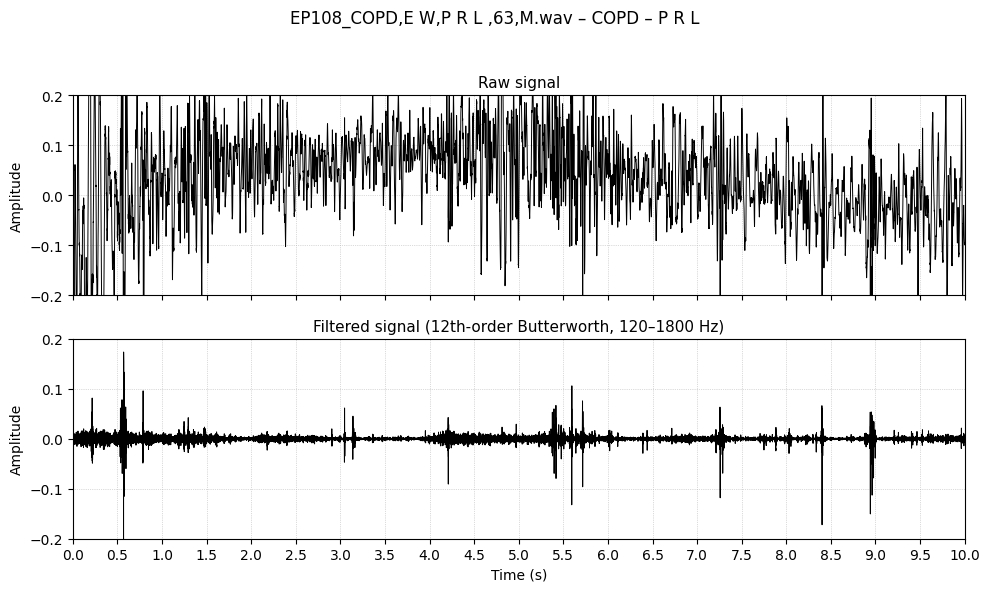

Playback (raw, fs=4000 Hz):


Playback (filtered, fs=4000 Hz):


In [10]:
example_row = ka_df.query("file_name == 'EP108_COPD,E W,P R L ,63,M.wav'").iloc[0]

# Zelfde stijl als jouw voorbeeld: 0–10 s, vaste y-as
plot_raw_vs_filtered_ka(
    example_row,
    time_window=(0.0, 10.0),
    fixed_ylim=(-0.2, 0.2)   # pas aan als je een andere schaal wilt
)


In [11]:
def make_ka_segments(df: pd.DataFrame, audio_col="filtered_audio", window_sec=2.5, hop_sec=1.0):
    segments = []
    for _, row in df.iterrows():
        y = row[audio_col]
        sr = row["sr"]
        win = int(round(window_sec * sr))
        hop = int(round(hop_sec * sr))

        if len(y) < win:
            continue

        idx = 0
        start = 0
        while start + win <= len(y):
            end = start + win
            segments.append({
                "file_name": row["file_name"],
                "patient_id": row["patient_id"],
                "diagnosis_norm": row.get("diagnosis_norm", row.get("diagnosis")),
                "location": row.get("location", None),
                "location_full": CHEST_LOCATION_MAP_KA.get(str(row.get("location","")).strip(), str(row.get("location","")).strip()),
                "segment_index": idx,
                "seg_start_sec": start / sr,
                "seg_end_sec": end / sr,
                "audio_segment": y[start:end],
                "sr": sr,
            })
            start += hop
            idx += 1
    return pd.DataFrame(segments)

ka_segments_df = make_ka_segments(ka_df, audio_col="filtered_audio", window_sec=2.5, hop_sec=1.0)
print("ka_segments_df shape:", ka_segments_df.shape)
ka_segments_df.head()


ka_segments_df shape: (5174, 10)


,file_name,patient_id,diagnosis_norm,location,location_full,segment_index,seg_start_sec,seg_end_sec,audio_segment,sr
0,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,0,0.0,2.5,"[0.002305793213411468, -0.0010046483761113915,...",4000
1,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,1,1.0,3.5,"[0.000886986761669791, 0.0007983855597659476, ...",4000
2,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,2,2.0,4.5,"[0.002227592108692823, 0.0032147203007522013, ...",4000
3,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,3,3.0,5.5,"[-0.00013071950858840162, -0.00058601715929976...",4000
4,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,4,4.0,6.5,"[0.004250724403487625, 0.004570283483968161, 0...",4000


In [12]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Audio

def segment_browser_widget(
    segments_df: pd.DataFrame,
    id_col: str,
    title_col: str = None,
    label_col: str = None,
    fixed_ylim=None,
):
    df = segments_df.copy()

    # Sort segments within each recording
    sort_cols = ["segment_index"] if "segment_index" in df.columns else ["seg_start_sec"]
    df = df.sort_values([id_col] + sort_cols)

    disp_col = title_col if title_col is not None else id_col

    # Build dropdown options safely (even if id_col == disp_col)
    if disp_col == id_col:
        unique_ids = pd.Series(df[id_col].unique()).dropna().sort_values()
        options = [(str(v), v) for v in unique_ids.tolist()]
    else:
        unique_rows = df[[id_col, disp_col]].drop_duplicates().dropna(subset=[id_col]).sort_values(disp_col)
        options = [(str(r[disp_col]), r[id_col]) for _, r in unique_rows.iterrows()]

    dropdown = widgets.Dropdown(
        options=options,
        description="Recording:",
        layout=widgets.Layout(width="520px"),
    )

    prev_btn = widgets.Button(description="Previous", layout=widgets.Layout(width="120px"))
    next_btn = widgets.Button(description="Next", layout=widgets.Layout(width="120px"))
    idx_label = widgets.Label(value="Segment: - / -", layout=widgets.Layout(width="160px"))

    out = widgets.Output()
    state = {"seg_pos": 0, "current_id": None, "current_sub": None}

    def _render():
        with out:
            clear_output(wait=True)

            rid = dropdown.value
            sub = df[df[id_col] == rid].reset_index(drop=True)
            state["current_id"] = rid
            state["current_sub"] = sub

            if len(sub) == 0:
                print("No segments found.")
                idx_label.value = "Segment: 0 / 0"
                return

            state["seg_pos"] = max(0, min(state["seg_pos"], len(sub) - 1))
            row = sub.iloc[state["seg_pos"]]

            seg_idx = int(row["segment_index"]) if "segment_index" in row else state["seg_pos"]
            start_s = float(row.get("seg_start_sec", np.nan))
            end_s = float(row.get("seg_end_sec", np.nan))

            label_txt = ""
            if label_col is not None and label_col in sub.columns:
                label_txt = f" | Label: {row[label_col]}"

            rec_name = str(rid)
            idx_label.value = f"Segment: {state['seg_pos']+1} / {len(sub)}"

            y = row["audio_segment"]
            sr = int(row["sr"])

            t = np.arange(len(y)) / sr
            fig, ax = plt.subplots(figsize=(10, 3))
            ax.plot(t, y, color="black", linewidth=0.7)

            if fixed_ylim is not None:
                ax.set_ylim(*fixed_ylim)

            ax.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.9)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude")
            ax.set_title(
                f"{rec_name} | Segment {seg_idx} | {start_s:.2f}s–{end_s:.2f}s{label_txt}",
                fontsize=11,
            )
            plt.tight_layout()
            plt.show()

            display(Audio(y, rate=sr))

    def _on_change(change):
        state["seg_pos"] = 0
        _render()

    def _on_prev(_):
        if state["current_sub"] is None:
            _render()
            return
        state["seg_pos"] = max(0, state["seg_pos"] - 1)
        _render()

    def _on_next(_):
        if state["current_sub"] is None:
            _render()
            return
        state["seg_pos"] = min(len(state["current_sub"]) - 1, state["seg_pos"] + 1)
        _render()

    dropdown.observe(_on_change, names="value")
    prev_btn.on_click(_on_prev)
    next_btn.on_click(_on_next)

    controls = widgets.HBox([dropdown, prev_btn, next_btn, idx_label])
    display(controls, out)
    _render()


In [13]:
segment_browser_widget(
    segments_df=ka_segments_df,
    id_col="file_name",
    title_col="file_name",
    label_col="diagnosis_norm",
    fixed_ylim=None,
)


Output()

In [14]:
ka_segments_df

,file_name,patient_id,diagnosis_norm,location,location_full,segment_index,seg_start_sec,seg_end_sec,audio_segment,sr
0,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,0,0.0,2.5,"[0.002305793213411468, -0.0010046483761113915,...",4000
1,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,1,1.0,3.5,"[0.000886986761669791, 0.0007983855597659476, ...",4000
2,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,2,2.0,4.5,"[0.002227592108692823, 0.0032147203007522013, ...",4000
3,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,3,3.0,5.5,"[-0.00013071950858840162, -0.00058601715929976...",4000
4,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,4,4.0,6.5,"[0.004250724403487625, 0.004570283483968161, 0...",4000
...,...,...,...,...,...,...,...,...,...,...
5169,"EP9_Asthma,E W,P R L ,59,M.wav",P9,Asthma,P R L,P R L,8,8.0,10.5,"[0.005460325616805489, 0.004919080369346557, 0...",4000
5170,"EP9_Asthma,E W,P R L ,59,M.wav",P9,Asthma,P R L,P R L,9,9.0,11.5,"[0.002296614229064719, 0.0013834398688546197, ...",4000
5171,"EP9_Asthma,E W,P R L ,59,M.wav",P9,Asthma,P R L,P R L,10,10.0,12.5,"[0.0017118079979643263, 0.0029594292568356864,...",4000
5172,"EP9_Asthma,E W,P R L ,59,M.wav",P9,Asthma,P R L,P R L,11,11.0,13.5,"[0.004115500547617479, 0.0048816566155640536, ...",4000


In [15]:
from pathlib import Path

sr_values = ka_segments_df["sr"].unique()
if len(sr_values) != 1:
    raise ValueError(f"Expected exactly one sampling rate, found: {sr_values}")

SR = int(sr_values[0])
print("Using sampling rate:", SR)

AUDIO_OUT_DIR = Path(f"../../data/processed/ka/audio_{SR}hz_bp_segments").resolve()
AUDIO_OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Audio output dir:", AUDIO_OUT_DIR)

Using sampling rate: 4000
Audio output dir: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\ka\audio_4000hz_bp_segments


In [16]:
import re
import numpy as np
import soundfile as sf

def safe_stem(s: str) -> str:
    """Make a filesystem-safe stem (keep letters, numbers, dash, underscore)."""
    s = Path(str(s)).stem
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^A-Za-z0-9_\-]+", "", s)
    return s

audio_paths = []
n_written = 0
n_skipped = 0

for _, row in ka_segments_df.iterrows():
    patient_id = str(row["patient_id"]).strip()
    stem = safe_stem(row["file_name"])
    seg_i = int(row["segment_index"])

    fname = f"{patient_id}_{stem}_seg{seg_i:03d}.wav"
    out_path = AUDIO_OUT_DIR / fname

    if out_path.exists():
        info = sf.info(out_path)
        if info.samplerate != SR:
            raise ValueError(
                f"Sampling rate mismatch for existing file {out_path}: {info.samplerate} != {SR}"
            )
        n_skipped += 1
    else:
        y = np.asarray(row["audio_segment"], dtype=np.float32)
        sf.write(out_path, y, SR, subtype="FLOAT")
        n_written += 1

    audio_paths.append(str(out_path))

print(f"Audio export done | written: {n_written} | skipped: {n_skipped}")

Audio export done | written: 5174 | skipped: 0


In [17]:
ka_segments_df

,file_name,patient_id,diagnosis_norm,location,location_full,segment_index,seg_start_sec,seg_end_sec,audio_segment,sr
0,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,0,0.0,2.5,"[0.002305793213411468, -0.0010046483761113915,...",4000
1,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,1,1.0,3.5,"[0.000886986761669791, 0.0007983855597659476, ...",4000
2,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,2,2.0,4.5,"[0.002227592108692823, 0.0032147203007522013, ...",4000
3,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,3,3.0,5.5,"[-0.00013071950858840162, -0.00058601715929976...",4000
4,"BP100_N,N,P R M,70,F.wav",P100,Normal,P R M,P R M,4,4.0,6.5,"[0.004250724403487625, 0.004570283483968161, 0...",4000
...,...,...,...,...,...,...,...,...,...,...
5169,"EP9_Asthma,E W,P R L ,59,M.wav",P9,Asthma,P R L,P R L,8,8.0,10.5,"[0.005460325616805489, 0.004919080369346557, 0...",4000
5170,"EP9_Asthma,E W,P R L ,59,M.wav",P9,Asthma,P R L,P R L,9,9.0,11.5,"[0.002296614229064719, 0.0013834398688546197, ...",4000
5171,"EP9_Asthma,E W,P R L ,59,M.wav",P9,Asthma,P R L,P R L,10,10.0,12.5,"[0.0017118079979643263, 0.0029594292568356864,...",4000
5172,"EP9_Asthma,E W,P R L ,59,M.wav",P9,Asthma,P R L,P R L,11,11.0,13.5,"[0.004115500547617479, 0.0048816566155640536, ...",4000


In [ ]:
# bepaal project root (consistent met je notebooks)
CWD = Path().resolve()
PROJECT_ROOT = CWD.parents[1]

# maak kopie zodat je origineel niet onverwacht wijzigt
df_out = ka_segments_df.copy()

def make_relative(p):
    if not isinstance(p, str):
        return p
    path = Path(p)
    if path.is_absolute():
        try:
            return path.relative_to(PROJECT_ROOT).as_posix()
        except ValueError:
            # pad ligt buiten project root → laat hem ongemoeid
            return p
    return p

df_out["audio_path"] = df_out["audio_path"].apply(make_relative)

# wegschrijven
OUT_DIR = Path("../../data/processed/ka").resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_META = OUT_DIR / "ka_segments.csv"
df_out.to_csv(OUT_META, index=False)

print("Metadata written to:", OUT_META)

Metadata written to: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\ka\ka_segments.csv
